In [1]:
import datetime
import os
import mthree
import numpy as np
from qiskit import IBMQ
from qiskit.providers.ibmq import IBMQBackend
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit_research.mzm_generation import KitaevHamiltonianExperiment
from qiskit_research.mzm_generation.utils import pick_qubit_layout, orbital_combinations

In [10]:
# get backend

# hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_guadalupe')

# Aer simulator backend
# noise_model = NoiseModel.from_backend(backend)
# backend = AerSimulator(method='density_matrix', noise_model=noise_model)

ibmqfactory.load_account:WARNING:2022-02-27 20:04:56,174: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
# Hamiltonian parameters
n_modes = 5
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = np.linspace(0.0, 3.0, num=5)
occupied_orbitals_list = list(orbital_combinations(n_modes, threshold=2))

# qubitsmetbase
qubits, backend_name, error_score = pick_qubit_layout(n_modes, [backend])
# qubits = list(range(n_modes))
print(f'Using qubits {qubits}.')

# number of shots
shots = 100000

# number of shots for readout error calibration
readout_calibration_shots = 100000

# date
date = datetime.datetime.now().isoformat()

# create experiments
experiment = KitaevHamiltonianExperiment(
    experiment_id=f'{date}_{backend.name()}',
    backend=backend,
    readout_calibration_date=date,
    qubits=qubits,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    dynamical_decoupling_sequences=['XY4pm']
)

Using qubits [11, 14, 13, 12, 15].


In [ ]:
%%time

# schedule readout calibration
print('Scheduling readout calibration ...')
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots)
# schedule experiment jobs
print(f'Scheduling experiment ...')
# limit number of circuits per job to avoid timeouts
backend.configuration().max_experiments = 150
data = experiment.run(shots=shots)
if isinstance(backend, IBMQBackend):
    data.save()

# save readout calibration
filename = f'data/readout_calibration/{backend.name()}/{date}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f'Waiting for readout calibration data ...')
mit.cals_to_file(filename)
print(f'Readout calibration saved.')

Scheduling readout calibration ...
Scheduling experiment ...
You can view the experiment online at https://quantum-computing.ibm.com/experiments/07679b6d-5176-4804-9ac1-d13a30a8520b
Waiting for readout calibration data ...


In [5]:
# wait for experiment results
# data.block_for_results()

# TODO save data locally once it's supported
# See https://github.com/Qiskit/qiskit-experiments/issues/602

In [6]:
# TODO split off into analysis notebook once Qiskit Experiments supports saving data
# See https://github.com/Qiskit/qiskit-experiments/issues/602
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis
np.set_printoptions(precision=3, suppress=True, linewidth=150)

In [7]:
%%time
experiment_id = data.metadata["experiment_id"]
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data)

fidelity_witness_avg_raw, fidelity_witness_stddev_raw = data.analysis_results('fidelity_witness_avg_raw').value
fidelity_witness_avg_mem, fidelity_witness_stddev_mem = data.analysis_results('fidelity_witness_avg_mem').value
fidelity_witness_avg_ps, fidelity_witness_stddev_ps = data.analysis_results('fidelity_witness_avg_ps').value
fidelity_witness_avg_pur, fidelity_witness_stddev_pur = data.analysis_results('fidelity_witness_avg_pur').value

energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value
energy_ps = data.analysis_results('energy_ps').value
energy_pur = data.analysis_results('energy_pur').value

bdg_energy_exact = data.analysis_results('bdg_energy_exact').value
bdg_energy_raw, bdg_energy_stddev_raw = data.analysis_results('bdg_energy_raw').value
bdg_energy_mem, bdg_energy_stddev_mem = data.analysis_results('bdg_energy_mem').value
bdg_energy_ps, bdg_energy_stddev_ps = data.analysis_results('bdg_energy_ps').value
bdg_energy_pur, bdg_energy_stddev_pur = data.analysis_results('bdg_energy_pur').value

# site_correlation_exact = data.analysis_results('site_correlation_exact').value

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

# set plot options
dpi = 150
filetype = 'png'

/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/utils.py:68: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")
/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/utils.py:245: RuntimeWarning: invalid value encountered in sqrt
  return np.real(witness), np.sqrt(np.real(var))


CPU times: user 2min 26s, sys: 2.09 s, total: 2min 28s
Wall time: 2min 26s


In [8]:
fidelity_witness_stddev_ps

array([0.002, 0.002, 0.002,   nan,   nan])

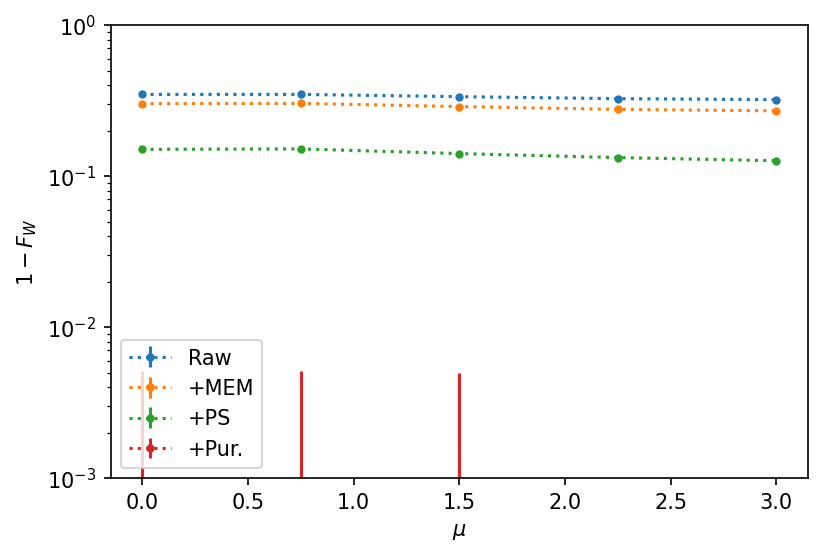

In [9]:
# plot fidelity witness
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_raw,
    yerr=2 * fidelity_witness_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_mem,
    yerr=2 * fidelity_witness_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_ps,
    yerr=2 * fidelity_witness_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_pur,
    yerr=2 * fidelity_witness_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$1 - F_W$")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend()

data.add_figures(fig, 'fidelity_witness', overwrite=True)
plt.savefig(f'plots/{experiment_id}/fidelity_witness.{filetype}')
plt.show()

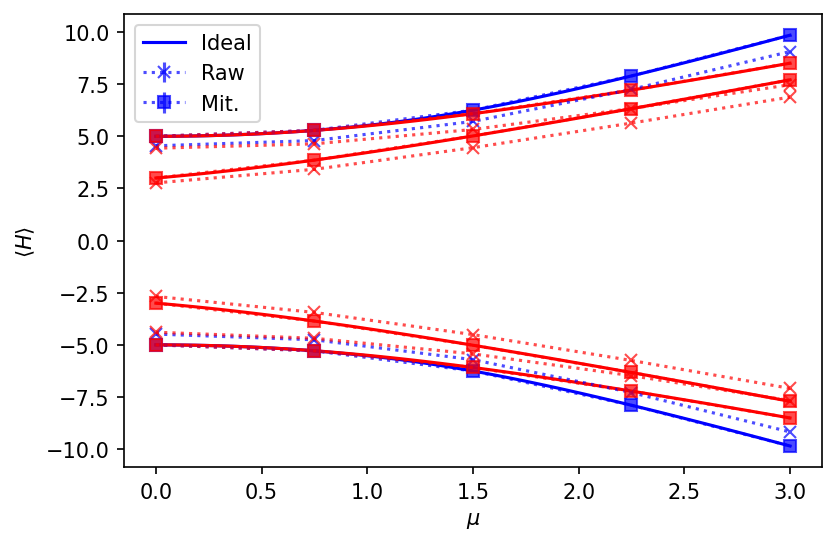

In [10]:
# plot energy
fig, ax = plt.subplots(dpi=dpi)
#occupied_orbitals_list = [(), (0,)]
occupied_orbitals_list = [tuple(o) for o in data.metadata["occupied_orbitals_list"]]
for i, occupied_orbitals in enumerate(occupied_orbitals_list):
    energies, xvals = energy_exact[occupied_orbitals]
    label = "Ideal" if not i else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        xvals, energies, label=label, color=color
    )
for i, occupied_orbitals in enumerate(occupied_orbitals_list):
    energies, stddevs = energy_raw[occupied_orbitals]
    label = "Raw" if not i else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for i, occupied_orbitals in enumerate(occupied_orbitals_list):
    energies, stddevs = energy_pur[occupied_orbitals]
    label = "Mit." if not i else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.legend()

data.add_figures(fig, 'energy', overwrite=True)
plt.savefig(f'plots/{experiment_id}/energy.{filetype}')
plt.show()